In [ ]:
# Cosas por hacer:
#    - Cambiar coordenadas esquinas
#
#

In [1]:
import copy
import glob
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import time
import tempfile
import shutil, shlex


from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from datetime import datetime
from funcs import *
from simulation_imports import *
from subprocess import check_call, STDOUT
from xspec import Xset, Plot, AllData, ModelManager, Spectrum, Model, AllModels, Fit

plt.style.use(astropy_mpl_style)



In [2]:
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"
SIXTE = os.environ["SIXTE"]
xmldir = "{}/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row".format(SIXTE)

xml0="{}/ld_wfi_ff_chip0.xml".format(xmldir)
xml1="{}/ld_wfi_ff_chip1.xml".format(xmldir)
xml2="{}/ld_wfi_ff_chip2.xml".format(xmldir)
xml3="{}/ld_wfi_ff_chip3.xml".format(xmldir)
#xmldir="./xmldir"

# NOTA: tienes que cambiar las coordenadas de las dos esquinas cuando salgan los nuevos xml. Yo lo hacía poniendo el ratón en el ds9. Son (RA, Dec). En principio solo tienes que cambiar los puntos. Borra esto cuando lo hagas

### $\textbf{Creating a SIMPUT for several sources with simputfile}$

In [3]:
simpar="XSPECFile=mcrab.xcm Emin=0.5 Emax=10.0 clobber=yes"
ra = [40.21, 40.31, 40.12, 40.27, 40.29, 40.33]
dec = [12.82, 12.83, 12.73, 12.81, 12.75, 12.81]
src_flux = [8.3e-12, 2.3e-11, 6.3e-12, 4.1e-12, 3.2e-11, 1.3e-11]
l = 0
rewrite = True
if rewrite:
    for i, j, k in zip(ra, dec, src_flux):
        sim_file = "src_0{}.fits".format(l)
        if os.path.exists(sim_file):
            os.remove(sim_file)
        run_comm("simputfile RA={} Dec={} srcFlux={} Simput={} {}".format(i, j, k, sim_file, simpar), 'Creating simput file: {}'.format(sim_file))
        l = l + 1
else:
    print("SIMPUT files already exist: they will not be overwritten") 
    
  # Merge the simput files

opt="clobber=yes FetchExtensions=yes"

infile1 = "src_0{}.fits".format(0)
infile2 = "src_0{}.fits".format(1)

rewrite = True
if rewrite:
    for i in range(5):
        if i == 4:
            outfile = "merged_simput.fits".format(i+1)
        else:
            outfile = "m_src_0{}.fits".format(i+1)
        if os.path.exists(outfile):
            os.remove(outfile)
        run_comm("simputmerge {} Infile1={} Infile2={} Outfile={}" .format(opt, infile1, infile2, outfile), 'Merginig {} and {} into {}'.format(infile1, infile2, outfile))

        infile2 = outfile
        infile1 = "src_0{}.fits".format(i+2)
else:
    print("SIMPUT files already exist: they will not be overwritten") 


Creating simput file: src_00.fits
simputfile RA=40.21 Dec=12.82 srcFlux=8.3e-12 Simput=src_00.fits XSPECFile=mcrab.xcm Emin=0.5 Emax=10.0 clobber=yes
Creating simput file: src_01.fits
simputfile RA=40.31 Dec=12.83 srcFlux=2.3e-11 Simput=src_01.fits XSPECFile=mcrab.xcm Emin=0.5 Emax=10.0 clobber=yes
Creating simput file: src_02.fits
simputfile RA=40.12 Dec=12.73 srcFlux=6.3e-12 Simput=src_02.fits XSPECFile=mcrab.xcm Emin=0.5 Emax=10.0 clobber=yes
Creating simput file: src_03.fits
simputfile RA=40.27 Dec=12.81 srcFlux=4.1e-12 Simput=src_03.fits XSPECFile=mcrab.xcm Emin=0.5 Emax=10.0 clobber=yes
Creating simput file: src_04.fits
simputfile RA=40.29 Dec=12.75 srcFlux=3.2e-11 Simput=src_04.fits XSPECFile=mcrab.xcm Emin=0.5 Emax=10.0 clobber=yes
Creating simput file: src_05.fits
simputfile RA=40.33 Dec=12.81 srcFlux=1.3e-11 Simput=src_05.fits XSPECFile=mcrab.xcm Emin=0.5 Emax=10.0 clobber=yes
Merginig src_00.fits and src_01.fits into m_src_01.fits
simputmerge clobber=yes FetchExtensions=yes 

In [4]:
svg_file = "athenawfi_fullframe.svg"
pdf_file = "athenawfi_fullframe.pdf"

rewrite = False
if rewrite:
    if os.path.exists(svg_file):
        os.remove(svg_file)
    run_comm("xml2svg XMLFiles={};{};{};{} SVGWidth=3000 Border=10 SVGName={}".format(xml0, xml1, xml2, xml3, svg_file), 'Getting chip geometry')
else:
    print('Image file already exists, it will not be overwritten')

run_comm("convert {} {}".format(svg_file, pdf_file), 'Converting svg to pdf')
# run_comm("xdg-open {}".format(pdf_file), 'Open the pdf image in the default app')

Image file already exists, it will not be overwritten
Converting svg to pdf
convert athenawfi_fullframe.svg athenawfi_fullframe.pdf


In [5]:
# Running simulation chip by chip with athenafism tool and then merging the 4 chips
rewrite = False
combined_file = 'sim_combined_evt.fits'
if rewrite:
    if os.path.exists(combined_file):
        os.remove(combined_file)
    
    run_comm("athenawfisim XMLFile0={} XMLFile1={} XMLFile2={} XMLFile3={} RA=40.2 Dec=12.80 Prefix=sim_ Simput=merged_simput.fits ".format(xml0, xml1, xml2, xml3)+
                 "EvtFile=evt.fits Exposure=1000 clobber=yes ", 'Simulating 4 chips')
    run_comm('ftmerge sim_chip0_evt.fits,sim_chip1_evt.fits,sim_chip2_evt.fits,sim_chip3_evt.fits {} clobber=yes'.format(combined_file), 'Merging 4 chips')
else:
    print('Event file {} already exist, it will not be overwritten'.format(combined_file))

# To inspect the final evt file (same effect as fv command)
f = fits.open(combined_file)
f.info()
print(f[1].columns.names)

Event file sim_combined_evt.fits already exist, it will not be overwritten
Filename: sim_combined_evt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      66   ()      
  1  EVENTS        1 BinTableHDU    120   148017R x 16C   [D, J, J, J, E, I, I, D, D, 2J, 2J, I, J, I, 9E, 9J]   
  2  STDGTI        1 BinTableHDU     25   1R x 2C   [D, D]   
['TIME', 'FRAME', 'PHA', 'PI', 'SIGNAL', 'RAWX', 'RAWY', 'RA', 'DEC', 'PH_ID', 'SRC_ID', 'TYPE', 'NPIXELS', 'PILEUP', 'SIGNALS', 'PHAS']


Creating WFI image
imgev EvtFile=sim_combined_evt.fits Image=sim_combined_img.fits CoordinateSystem=0 Projection=TAN NAXIS1=1063 NAXIS2=1063 CUNIT1=deg CUNIT2=deg CRVAL1=40.2 CRVAL2=12.8 CRPIX1=532 CRPIX2=532 CDELT1=-0.0006207043 CDELT2=0.0006207043 history=true clobber=yes


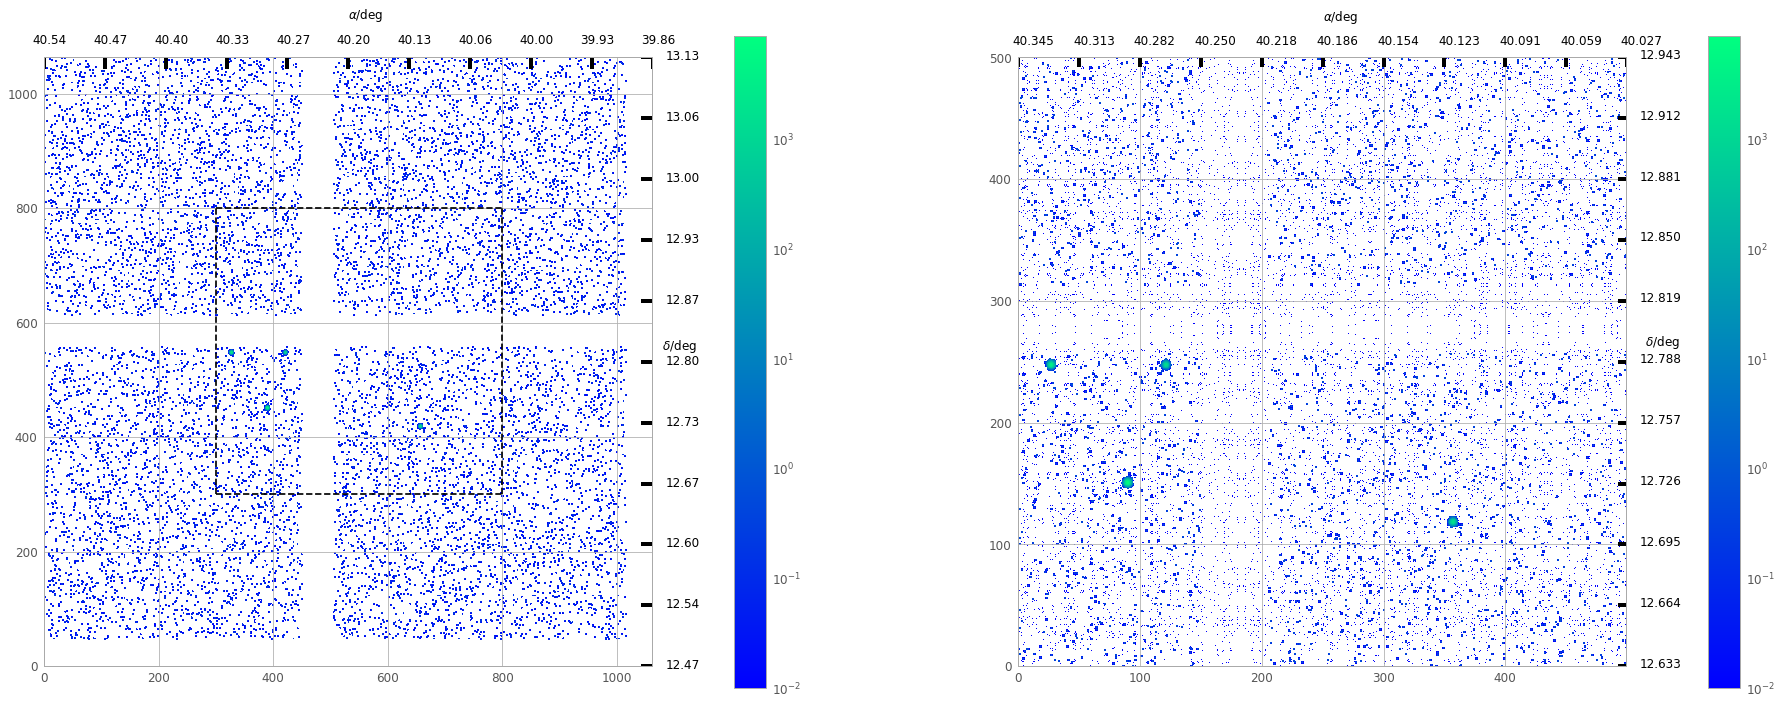

In [9]:
# Creating image of the detector with imgev
rewrite = True
img_file = 'sim_combined_img.fits'

if rewrite:
    if os.path.exists(img_file):
        os.remove(img_file)
    create_image_WFI(EvtFile=combined_file, Image=img_file, CoordinateSystem=0, Projection='TAN', NAXIS1=1063, NAXIS2=1063, CUNIT1='deg', CUNIT2='deg', 
                     CRVAL1=40.2, CRVAL2=12.8, CRPIX1=532, CRPIX2=532, CDELT1=-6.207043e-4, CDELT2=6.207043e-4)

else:
    print('Image file {} already exist, it will not be overwritten'.format(img_file))


image_data = fits.getdata(img_file, ext=0)
fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(16*2,6*2))
axs = _axs.flatten()
cmap = plt.cm.winter

# Cambia estas coordenadas cogiendo las nuevas del ./ds9 cuando salgan los xml (solo pon el ratón encima)

sq_downleft=np.array((40.536, 12.47))
sq_upright=np.array((39.86, 13.129))


draw_second_axis(fig, axs, sq_downleft=sq_downleft, sq_upright=sq_upright, ln=1063, mov_ra=20, mov_dec=5, lon_lines=17, num_lines=10,
                mov_x_text=[0, 67], mov_y_text=[17, 20], xlabel=r'$\alpha$/deg', ylabel=r'$\delta$/deg', num_axis=0, dist_txt=23, zero_between=False, display_format='.2f')



sq1, sq2 = get_zoom_coord(sq_downleft, sq_upright, ln=1063,  x=[300, 800], y=[300, 800])


draw_second_axis(fig, axs, sq_downleft=sq1, sq_upright=sq2, ln=500, mov_ra=5, mov_dec=1, lon_lines=6, num_lines=10,
                 mov_x_text=[0, 30], mov_y_text=[15, 13], xlabel=r'$\alpha$/deg', ylabel=r'$\delta$/deg', num_axis=1, dist_txt=10, zero_between=False, display_format='.3f')

axs[0].set_ylim(0, len(image_data))

axs[0].plot([300, 300], [300, 800], 'k--')
axs[0].plot([800, 800], [300, 800], 'k--')
axs[0].plot([300, 800], [300, 300], 'k--')
axs[0].plot([300, 800], [800, 800], 'k--')

im = axs[0].imshow(image_data, cmap=cmap, norm=colors.LogNorm(vmin=0.01, vmax=np.max(image_data)))
fig.colorbar(im,ax=axs[0], pad=0.1)

img2 = image_data[300:800, 300:800]
axs[1].set_ylim(0, len(img2))

im = axs[1].imshow(img2, cmap=cmap, norm=colors.LogNorm(vmin=0.01, vmax=np.max(image_data)))
fig.colorbar(im,ax=axs[1], pad=0.1)

In [12]:
# Create spectrum
spec_file = 'sim_combined_spec.pha'
rewrite = True
if rewrite:
    if os.path.exists(spec_file):
        os.remove(spec_file)
    run_comm("makespec EvtFile={} Spectrum={} clobber=yes RSPPath={} EventFilter='(RA>40.10 && RA<40.14) && Dec>12.70 && Dec<12.75'".format(combined_file, spec_file, xmldir), 'Generating spectrum')
else:
    print('Spec file {} already exists, it will not be overwritten'.format(spec_file))


Generating spectrum
makespec EvtFile=sim_combined_evt.fits Spectrum=sim_combined_spec.pha clobber=yes RSPPath=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row EventFilter='(RA>40.10 && RA<40.14) && Dec>12.70 && Dec<12.75'


In [13]:
Plot.device = '/null'
AllData.clear()
AllModels.clear()

Plot.device = "/xs"
Plot.xAxis="KeV"

# rebin spectral data
base = "mcrab"
binspec = "spec_{}_rebin_df.pha".format(base)

rewrite = False
if rewrite:
    if os.path.exists(binspec):
            os.remove(binspec)
    comm = ("grppha infile={} outfile={} clobber=yes comm='group min 20 & exit'".format(spec_file, binspec))    
    run_comm(comm, "Rebinning spectrum")
else:
    print("Rebin file ({}) already exists: it will not be overwritten".format(binspec))

AllData.clear()
s1 = Spectrum(spec_file)
s1.ignore("**-0.005")
s1.ignore("10.0-**")
s1.ignore("bad")
Plot("ldata")


Rebin file (spec_mcrab_rebin_df.pha) already exists: it will not be overwritten


---> Espectro no coincide y falta una fuente en el detector

In [19]:
# Simulating Chandra Deep Field South

    # Running simulation chip by chip with athenafism tool and merging the event files
rewrite = False
prefix = "cdfs_"
combined_file = '{}combined_evt.fits'.format(prefix)
if rewrite:
    if os.path.exists(combined_file):
        os.remove(combined_file)
    
    run_comm("athenawfisim XMLFile0={} XMLFile1={} XMLFile2={} XMLFile3={} RA=53.13 Dec=-27.8 Prefix={} Simput=CDFS_cat_lehmer.fits ".format(xml0, xml1, xml2, xml3, prefix)+
                 "Simput2=CDFS_cat_galaxies.fits EvtFile=evt.fits Exposure=5000 clobber=yes ", 'Simulating 4 chips')
    run_comm('ftmerge {}chip0_evt.fits,{}chip1_evt.fits,{}chip2_evt.fits,{}chip3_evt.fits {} clobber=yes'.format(prefix, prefix, prefix, prefix, combined_file), 'Merging 4 chips')
else:
    print('Event file {} already exists, it will not be overwritten'.format(combined_file))

    # To inspect the final evt file (same effect as fv command)
f = fits.open(combined_file)
f.info()
print(f[1].columns.names)

Event file cdfs_combined_evt.fits already exists, it will not be overwritten
Filename: cdfs_combined_evt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      66   ()      
  1  EVENTS        1 BinTableHDU    120   117163R x 16C   [D, J, J, J, E, I, I, D, D, 2J, 2J, I, J, I, 9E, 9J]   
  2  STDGTI        1 BinTableHDU     25   1R x 2C   [D, D]   
['TIME', 'FRAME', 'PHA', 'PI', 'SIGNAL', 'RAWX', 'RAWY', 'RA', 'DEC', 'PH_ID', 'SRC_ID', 'TYPE', 'NPIXELS', 'PILEUP', 'SIGNALS', 'PHAS']


Image file cdfs_combined_img.fits already exists, it will not be overwritten
Opening image
xdg-open imgs/chandra_deep_field.png


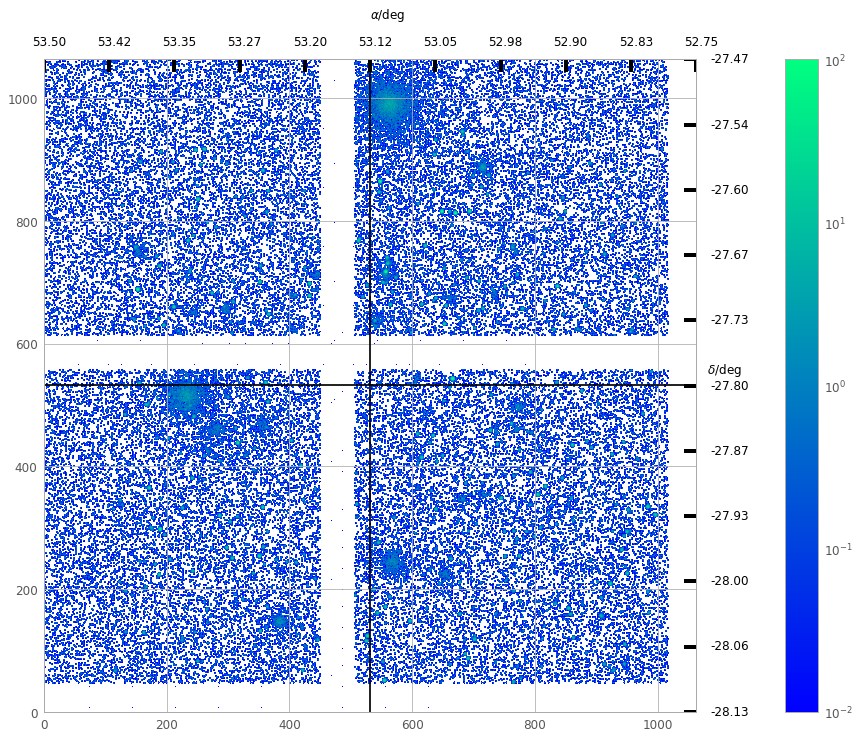

In [67]:
# Creating image of the detector with imgev
rewrite = False
img_file = '{}combined_img.fits'.format(prefix)

if rewrite:
    if os.path.exists(img_file):
        os.remove(img_file)
    create_image_WFI(EvtFile=combined_file, Image=img_file, CoordinateSystem=0, Projection='TAN', NAXIS1=1063, NAXIS2=1063, CUNIT1='deg', CUNIT2='deg', 
                     CRVAL1=53.13, CRVAL2=-27.8, CRPIX1=532, CRPIX2=532, CDELT1=-6.207043e-4, CDELT2=6.207043e-4)

else:
    print('Image file {} already exists, it will not be overwritten'.format(img_file))

axs = []
image_data = fits.getdata(img_file, ext=0)
fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(16*2,6*2))
axs.append(_axs)

# Cruz: quitar cuando esté corregido.
axs[0].plot([532, 532], [0,len(image_data)], 'k-')
axs[0].plot([0,len(image_data)], [532, 532],  'k-')

sq_downleft = np.array((53.50, -28.13))  ######### CAMBIAR COORDENADAS CON NUEVO XML ##########
sq_upright = np.array((52.75, -27.47))

draw_second_axis(fig, axs, sq_downleft=sq_downleft, sq_upright=sq_upright, ln=1063, mov_ra=20, mov_dec=5, lon_lines=17, num_lines=10,
                mov_x_text=[0, 67], mov_y_text=[17, 20], xlabel=r'$\alpha$/deg', ylabel=r'$\delta$/deg', num_axis=0, dist_txt=23, zero_between=False, display_format='.2f')


plt.ylim(0, len(image_data))
cmap = plt.cm.winter
im = axs[0].imshow(image_data, cmap=cmap, norm=colors.LogNorm(vmin=0.01, vmax=100))
fig.colorbar(im,ax=_axs)


#run_comm('./ds9 {}'.format(img_file))

In [27]:
# Attitude file
f = fits.open('CDFS_lissajous_80ksec.att')
ra = f[1].data['RA']
dec = f[1].data['Dec']


In [28]:
# Obtaining exposure map
rewrite = False
expo_map = 'expo_map.fits'

if rewrite:
    if os.path.exists(expo_map):
        os.remove(expo_map)
    run_comm('exposure_map Vignetting={}/athena_vig_15row_20171016.fits Attitude=CDFS_lissajous_80ksec.att Exposuremap={} '.format(xmldir, expo_map) +
            'XMLFile={};{};{};{} fov_diameter=70 CoordinateSystem=0 projection_type=TAN NAXIS1=1063 NAXIS2=1063 CUNIT1=deg CUNIT2=deg '.format(xml0, xml1, xml2, xml3) +
            'CRVAL1=53.13 CRVAL2=-27.8 CRPIX1=532 CRPIX2=532 CDELT1=-6.207043e-04 CDELT2=6.207043e-04 TSTART=0 timespan=5000.000000 dt=100. chatter=3 clobber=true',
             'Calculating exposure map')
else:
    print('Exposure map file {} already exists, it will not be overwritten'.format(expo_map))

f = fits.open(expo_map)
data = f[0].data


Exposure map file expo_map.fits already exists, it will not be overwritten


Opening image
xdg-open imgs/exposure_map_deep_field.png


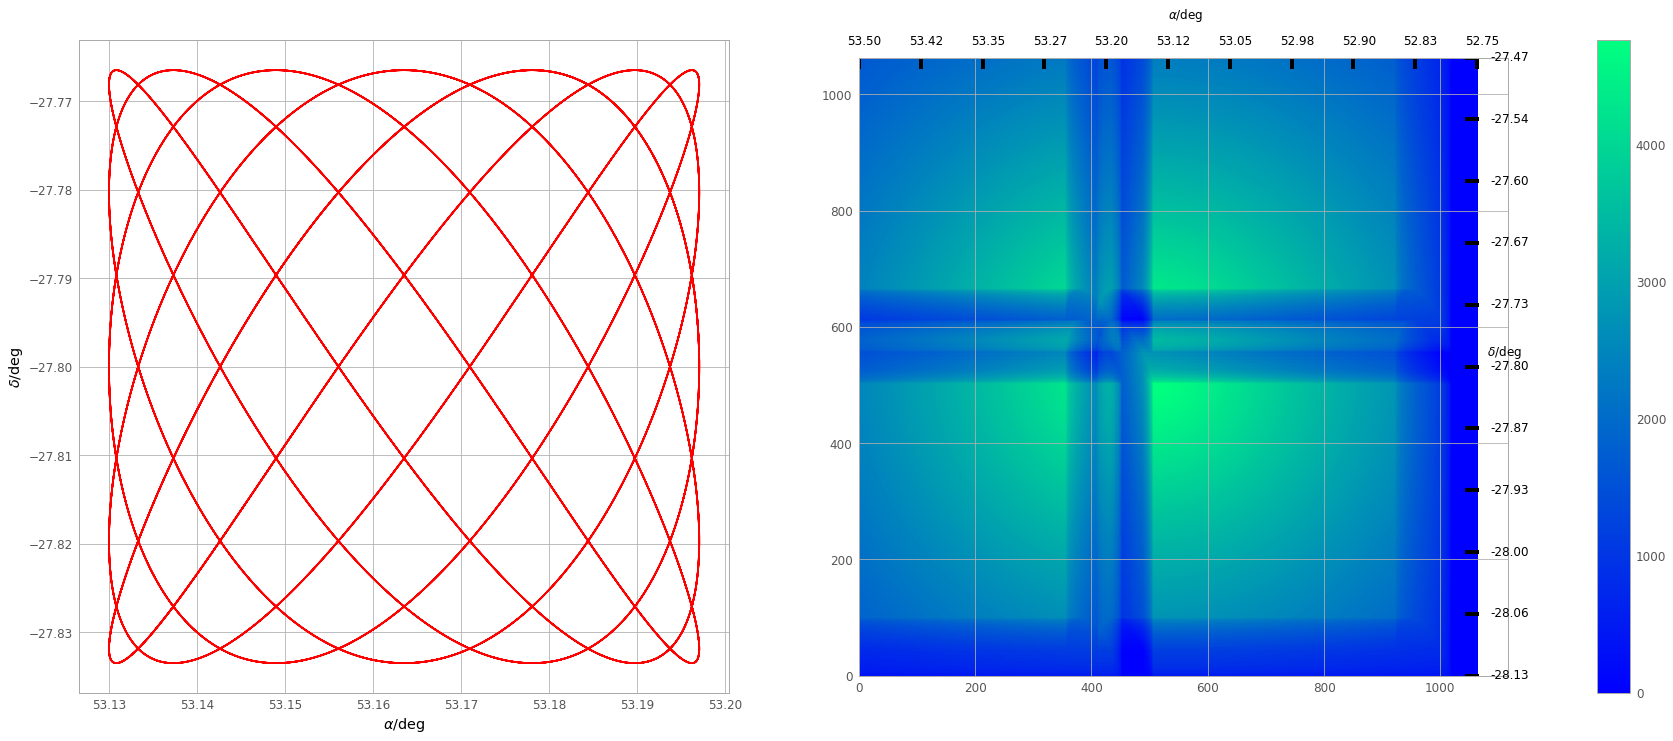

In [32]:
fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(16*2,6*2))
axs = _axs.flatten()
axs[0].plot(ra, dec, 'r-')
axs[0].set_ylabel(r'$\delta$/deg')
axs[0].set_xlabel(r'$\alpha$/deg')

im = axs[1].imshow(data, cmap=cmap)
fig.colorbar(im,ax=axs)

draw_second_axis(fig, axs, sq_downleft=sq_downleft, sq_upright=sq_upright, ln=1063, mov_ra=20, mov_dec=5, lon_lines=17, num_lines=10,
                mov_x_text=[0, 67], mov_y_text=[17, 20], xlabel=r'$\alpha$/deg', ylabel=r'$\delta$/deg', num_axis=1, dist_txt=23, zero_between=False, display_format='.2f')



axs[1].set_ylim(0, len(image_data))



In [30]:
# Run new simulation without the detector gaps

rewrite = True
merged_combined_nogap = 'sc_att_combined_evt.fits'

if rewrite:
    if os.path.exists(merged_combined_nogap):
        os.remove(merged_combined_nogap)
    run_comm('athenawfisim RA=53.13 Dec=-27.8 Attitude=CDFS_lissajous_80ksec.att Prefix=c_att_ '+
             'XMLFile0={} XMLFile1={} XMLFile2={} XMLFile3={} '.format(xml0, xml1, xml2, xml3) +
            'Simput=CDFS_cat_lehmer.fits Simput2=CDFS_cat_galaxies.fits Exposure=5000 clobber=yes', 'Simulating 4 chips')

    run_comm('ftmerge c_att_chip0_evt.fits,c_att_chip1_evt.fits,c_att_chip2_evt.fits,c_att_chip3_evt.fits {} clobber=yes'.format(merged_combined_nogap), 'Merging 4 event files')
else:
    print('Event file {} already exists, it will not be overwritten'.format(merged_combined_nogap))


Simulating 4 chips
athenawfisim RA=53.13 Dec=-27.8 Attitude=CDFS_lissajous_80ksec.att Prefix=c_att_ XMLFile0=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_chip0.xml XMLFile1=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_chip1.xml XMLFile2=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_chip2.xml XMLFile3=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_chip3.xml Simput=CDFS_cat_lehmer.fits Simput2=CDFS_cat_galaxies.fits Exposure=5000 clobber=yes
Merging 4 event files
ftmerge c_att_chip0_evt.fits,c_att_chip1_evt.fits,c_att_chip2_evt.fits,c_att_chip3_evt.fits sc_att_combined_evt.fits clobber=yes



imgev EvtFile=sc_att_combined_evt.fits Image=c_att_combined_img.fits CoordinateSystem=0 Projection=TAN NAXIS1=1063 NAXIS2=1063 CUNIT1=deg CUNIT2=deg CRVAL1=53.13 CRVAL2=-27.8 CRPIX1=532 CRPIX2=532 CDELT1=-6.207043e-04 CDELT2=6.207043e-04 history=true clobber=yes
Opening image
xdg-open imgs/chandra_filled_deep_field.png


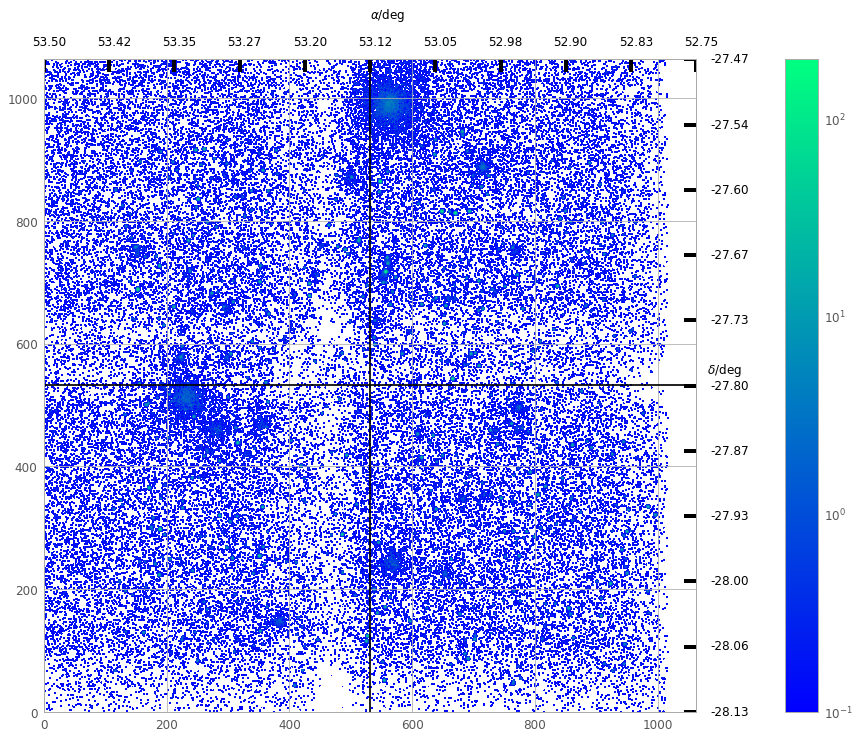

In [66]:
rewrite = True
img_file = 'c_att_combined_img.fits'
if rewrite:
    if os.path.exists(img_file):
        os.remove(img_file)
    run_comm('imgev EvtFile={} Image={} CoordinateSystem=0 Projection=TAN NAXIS1=1063 '.format(merged_combined_nogap, img_file) +
             'NAXIS2=1063 CUNIT1=deg CUNIT2=deg CRVAL1=53.13 CRVAL2=-27.8 CRPIX1=532 CRPIX2=532 CDELT1=-6.207043e-04 CDELT2=6.207043e-04 history=true clobber=yes')
    
else:
    print('Image file {} already exists, it will not be overwritten'.format(img_file))

axs = []
image_data = fits.getdata(img_file, ext=0)
fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(16*2,6*2))
axs.append(_axs)
axs[0].plot([532, 532], [0,len(image_data)], 'k-')
axs[0].plot([0,len(image_data)], [532, 532],  'k-')

draw_second_axis(fig, axs, sq_downleft=sq_downleft, sq_upright=sq_upright, ln=1063, mov_ra=20, mov_dec=5, lon_lines=17, num_lines=10,
                mov_x_text=[0, 67], mov_y_text=[17, 20], xlabel=r'$\alpha$/deg', ylabel=r'$\delta$/deg', num_axis=0, dist_txt=23, zero_between=False, display_format='.2f')


plt.ylim(0, len(image_data))
cmap = plt.cm.winter
im = axs[0].imshow(image_data, cmap=cmap, norm=colors.LogNorm(vmin=np.min(image_data)+0.1, vmax=np.max(image_data), clip=True))
fig.colorbar(im,ax=_axs)
img_subplot(fig, axs[0], 1.5, 1.2, 'imgs/chandra_filled_deep_field.png', True)
